# Gait and Localization Evaluation

- statistic analysis of the gait/drive with IMU and Twist data
- localization analysis with NDT and EKF performance parameter
- for Simulation only: localization evaluation with ground truth data from the Simulator (e.g. Isaac Sim)
- creation of correlation matrices, evaluation tables and other plots for visualization

In [2]:
# Rosbag path's
root="/bag_files/"
rosbag_list = [["rosbag2_2024_11_20-14_46_12", True, "straight, 1m/s, flat"]] #1

number = 1 #number from rosbag_list for visualization
rosbag_path = root+rosbag_list[number-1][0]
SIMULATION = rosbag_list[number-1][1]
FILTER = False #if True, the Data is zero phase filtered before further calculations

In [12]:
# Extract IMU, Twist data, ndt and ekf diagnostics and tf
import numpy as np
import rosbag2_py
from sensor_msgs.msg import Imu
from geometry_msgs.msg import TwistWithCovarianceStamped
from tf2_msgs.msg import TFMessage
import rclpy
from rclpy.serialization import deserialize_message
from statistics import variance
from scipy.spatial.transform import Rotation as R
from diagnostic_msgs.msg import DiagnosticArray
from typing import List

BLUE = '#0072BD'
ORANGE = '#D95319'
YELLOW = '#EDB120'

def extract_rosbag(rosbag_path, simulation_=False):
    def timestamps_to_seconds(list_):
        list_[0] = [(t - list_[0][0]) * 1e-9 for t in list_[0]] 
        return list_
    
    # Topic names
    imu_topic = "/sensing/imu/imu_data"
    twist_topic = "/sensing/vehicle_velocity_converter/twist_with_covariance"

    # Create a reader for the rosbag2
    storage_options = rosbag2_py.StorageOptions(uri=rosbag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')

    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)

    # Get all topics and types in the bag to ensure correct deserialization
    topic_types = reader.get_all_topics_and_types()
    type_dict = {topic.name: topic.type for topic in topic_types}


    # imu: [[timestamps (1)], [orientation (3)], [ang.vel. (3)], [lin.acc. (3)]]
    imu = [[], [[], [], []], [[], [], []], [[], [], []]]
    # twist: [[timestamps (1)], [linear (3)], [angular (3)]]
    twist = [[], [[], [], []], [[], [], []]]
    # ndt diagnostics [[timestamp], [transform_probability, [execution_time]], :
    ndt_diagnostics = [[], [], []]
    
    if simulation_:
        # ekf diagnostics [[timestamp], [mahalanobis_distance_pose, [mahalanobis_distance_twist]], :
        ekf_diagnostics = [[], [], []]
        # tf_base_link: [[timestamps (1)], [translation (3)], [rotation (4)]]
        tf = [[], [[], [], []], [[], [], [], []]]
        # tf_base_link_ground_truth: [[timestamps (1)], [translation (3)], [rotation (4)]]
        tf_gt = [[], [[], [], []], [[], [], [], []]]
    
    while reader.has_next():
        (topic, data, t) = reader.read_next()
        if(rosbag_path[-27:] == "rosbag2_2024_12_03-09_11_03" and t > 1733213602658867979): #skip last 5 seconds of a certain rosbag
            pass
        
        elif topic == imu_topic and type_dict[topic] == 'sensor_msgs/msg/Imu':
            msg = deserialize_message(data, Imu)
            # Append timestamp and IMU data (Orientation in Euler)
            rotation = R.from_quat([msg.orientation.x, msg.orientation.y, msg.orientation.z, msg.orientation.w])
            orientation_euler = rotation.as_euler('xyz', degrees=False)
            imu[0].append(t)
            imu[1][0].append(orientation_euler[0])
            imu[1][1].append(orientation_euler[1])
            imu[1][2].append(orientation_euler[2])
            imu[2][0].append(msg.angular_velocity.x)
            imu[2][1].append(msg.angular_velocity.y)
            imu[2][2].append(msg.angular_velocity.z)
            imu[3][0].append(msg.linear_acceleration.x)
            imu[3][1].append(msg.linear_acceleration.y)
            imu[3][2].append(msg.linear_acceleration.z)
            
        elif topic == twist_topic and type_dict[topic] == 'geometry_msgs/msg/TwistWithCovarianceStamped':
            msg = deserialize_message(data, TwistWithCovarianceStamped)
            # Append timestamp and Twist data
            twist[0].append(t)
            twist[1][0].append(msg.twist.twist.linear.x)
            twist[1][1].append(msg.twist.twist.linear.y)
            twist[1][2].append(msg.twist.twist.linear.z)
            twist[2][0].append(msg.twist.twist.angular.x)
            twist[2][1].append(msg.twist.twist.angular.y)
            twist[2][2].append(msg.twist.twist.angular.z)

        elif topic == "/tf" and type_dict[topic] == 'tf2_msgs/msg/TFMessage' and simulation_ == True:
            msg = deserialize_message(data, TFMessage)
            if msg.transforms[0].header.frame_id == 'map' and msg.transforms[0].child_frame_id == 'base_link':
                tf[0].append(t)
                tf[1][0].append(msg.transforms[0].transform.translation.x)
                tf[1][1].append(msg.transforms[0].transform.translation.y)
                tf[1][2].append(msg.transforms[0].transform.translation.z)
                tf[2][0].append(msg.transforms[0].transform.rotation.x)
                tf[2][1].append(msg.transforms[0].transform.rotation.y)
                tf[2][2].append(msg.transforms[0].transform.rotation.z)
                tf[2][3].append(msg.transforms[0].transform.rotation.w)
            elif msg.transforms[0].header.frame_id == 'map' and msg.transforms[0].child_frame_id == 'base_link_ground_truth':
                tf_gt[0].append(t)
                tf_gt[1][0].append(msg.transforms[0].transform.translation.x)
                tf_gt[1][1].append(msg.transforms[0].transform.translation.y)
                tf_gt[1][2].append(msg.transforms[0].transform.translation.z)
                tf_gt[2][0].append(msg.transforms[0].transform.rotation.x)
                tf_gt[2][1].append(msg.transforms[0].transform.rotation.y)
                tf_gt[2][2].append(msg.transforms[0].transform.rotation.z)
                tf_gt[2][3].append(msg.transforms[0].transform.rotation.w)

        elif topic == '/diagnostics' and type_dict["/diagnostics"] == 'diagnostic_msgs/msg/DiagnosticArray':
            msg = deserialize_message(data, DiagnosticArray)
            for status in msg.status: 
                if 'ndt_scan_matcher: scan_matching_status' == status.name:
                    if 'OK' == status.message: 
                        ndt_diagnostics[0].append(t)
                        for kv in status.values:
                            key = kv.key
                            value = kv.value
                            if 'transform_probability' == key:
                                ndt_diagnostics[1].append(float(value))
                            if 'execution_time' == key:
                                ndt_diagnostics[2].append(float(value))

                if 'localization: ekf_localizer' == status.name and simulation_ == True:
                    ekf_diagnostics[0].append(t)
                    for kv in status.values:
                        key = kv.key
                        value = kv.value
                        if 'mahalanobis_distance_pose_' == key:
                            ekf_diagnostics[1].append(float(value))
                        if 'mahalanobis_distance_twist_' == key:
                            ekf_diagnostics[2].append(float(value))

    # convert to seconds
    imu = timestamps_to_seconds(imu)  
    twist = timestamps_to_seconds(twist)  
    ndt_diagnostics = timestamps_to_seconds(ndt_diagnostics)  
    if simulation_:
        ekf_diagnostics = timestamps_to_seconds(ekf_diagnostics)  
        tf = timestamps_to_seconds(tf)  
        tf_gt = timestamps_to_seconds(tf_gt)  
    
    if simulation_:
        return imu, twist, ndt_diagnostics, ekf_diagnostics, tf, tf_gt
    else: 
        imu[3][2] = np.array(imu[3][2]) - 9.81
        return imu, twist, ndt_diagnostics


def calc_derivation(twist, imu):
    # Calculates the derivatives of the velocities in the twist nested list using the Second-Order Central Difference method.
    
    def second_order_central_difference(values: List[float], times: List[float]) -> List[float]:
        #Calculate the second-order central difference derivative
        n = len(values)
        derivatives = [0.0] * n

        for i in range(n):
            if i >= 2 and i < n - 2:
                # Second-order central difference
                delta_t = times[i + 1] - times[i]
                derivatives[i] = ( -values[i + 2] + 8 * values[i + 1] - 8 * values[i - 1] + values[i - 2] ) / (12 * delta_t)
            elif i == 0 or i == 1:
                # Forward difference for the first two points
                derivatives[i] = (values[i + 1] - values[i]) / (times[i + 1] - times[i])
            else:
                # Backward difference for the last two points
                derivatives[i] = (values[i] - values[i - 1]) / (times[i] - times[i - 1])
        return derivatives

    if SIMULATION:
        # Calculate accelerations (linear and angular)
        linear_acc = [ second_order_central_difference(twist[1][i], twist[0]) for i in range(3) ]
        angular_acc = [ second_order_central_difference(twist[2][i], twist[0]) for i in range(3) ]
    else:
        twist[2] = imu[2] # copy angular velocity from IMU
        linear_acc = imu[3] #copy linear acc. from IMU
        angular_acc = [ second_order_central_difference(twist[2][i], imu[0]) for i in range(3) ]
        angular_acc[2][0] = 0
    
    return twist, [twist[0], linear_acc, angular_acc]
    

if SIMULATION:
    imu, twist, ndt_diagnostics, ekf_diagnostics, tf, tf_gt = extract_rosbag(rosbag_path, SIMULATION)
else:
    imu, twist, ndt_diagnostics = extract_rosbag(rosbag_path, SIMULATION)

[INFO] [1737551344.355096912] [rosbag2_storage]: Opened database '/home/kinbergeradm/bag_files/gait_localization_evaluation/rosbag2_2024_12_03-10_34_42/rosbag2_2024_12_03-10_34_42_0.db3' for READ_ONLY.


In [13]:
# Zero Phase filter
from scipy.signal import butter, filtfilt

def calculate_sampling_rate(timestamps):
    time_intervals = np.diff(timestamps)
    mean_interval = np.mean(time_intervals)
    return 1 / mean_interval

def zero_phase_filter(data, sampling_rate, N_):
    b, a = butter(N=N_, Wn=sampling_rate/2, btype='low', fs=sampling_rate*10)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def filter_all_data(imu_, twist_, ndt_diagnostics_, ekf_diagnostics_, tf_, tf_gt_, twist_acc_):
    fs_imu = calculate_sampling_rate(imu_[0]) 
    fs_twist = calculate_sampling_rate(twist_[0]) 
    fs_ndt = calculate_sampling_rate(ndt_diagnostics_[0])
    fs_ekf = calculate_sampling_rate(ekf_diagnostics_[0])
    fs_tf = calculate_sampling_rate(tf_[0])
    fs_tf_gt = calculate_sampling_rate(tf_gt_[0])
    
    for i in range(1,4): 
        for j in range(3):
            imu_[i][j] = zero_phase_filter(imu_[i][j], fs_imu, 1)  
    for i in range(1,3): 
        ndt_diagnostics_[i] = zero_phase_filter(ndt_diagnostics_[i], fs_ndt, 1)
        ekf_diagnostics_[i] = zero_phase_filter(ekf_diagnostics_[i], fs_ekf, 1)
        for j in range(3):
            twist_[i][j] = zero_phase_filter(twist_[i][j], fs_twist, 1)
            twist_acc_[i][j] = zero_phase_filter(twist_acc_[i][j], fs_twist, 1)
    for j in range(3):
        tf_[1][j] = zero_phase_filter(tf_[1][j], fs_tf, 1)
        tf_gt_[1][j] = zero_phase_filter(tf_gt_[1][j], fs_tf_gt, 1)
    for j in range(4):
        tf_[2][j] = zero_phase_filter(tf_[2][j], fs_tf, 1)
        tf_gt_[2][j] = zero_phase_filter(tf_gt_[2][j], fs_tf_gt, 1)
    
    return imu_, twist_, ndt_diagnostics_, ekf_diagnostics_, tf_, tf_gt_, twist_acc_

def filter_imu(imu_):
    fs_imu = calculate_sampling_rate(imu_[0])
    
    for i in range(1,4): 
        for j in range(3):
            imu_[i][j] = zero_phase_filter(imu_[i][j], fs_imu, 2)  

    imu[0] = imu[0][0::2]
    for i in range(1,4): 
        for j in range(3):
            imu[i][j] = imu[i][j][0::2]

    return imu_

if not SIMULATION:
    imu = filter_imu(imu)

twist, twist_acc = calc_derivation(twist, imu)

if FILTER:
    imu, twist, ndt_diagnostics, ekf_diagnostics, tf, tf_gt, twist_acc = filter_all_data(imu, twist, ndt_diagnostics, ekf_diagnostics, tf, tf_gt, twist_acc)

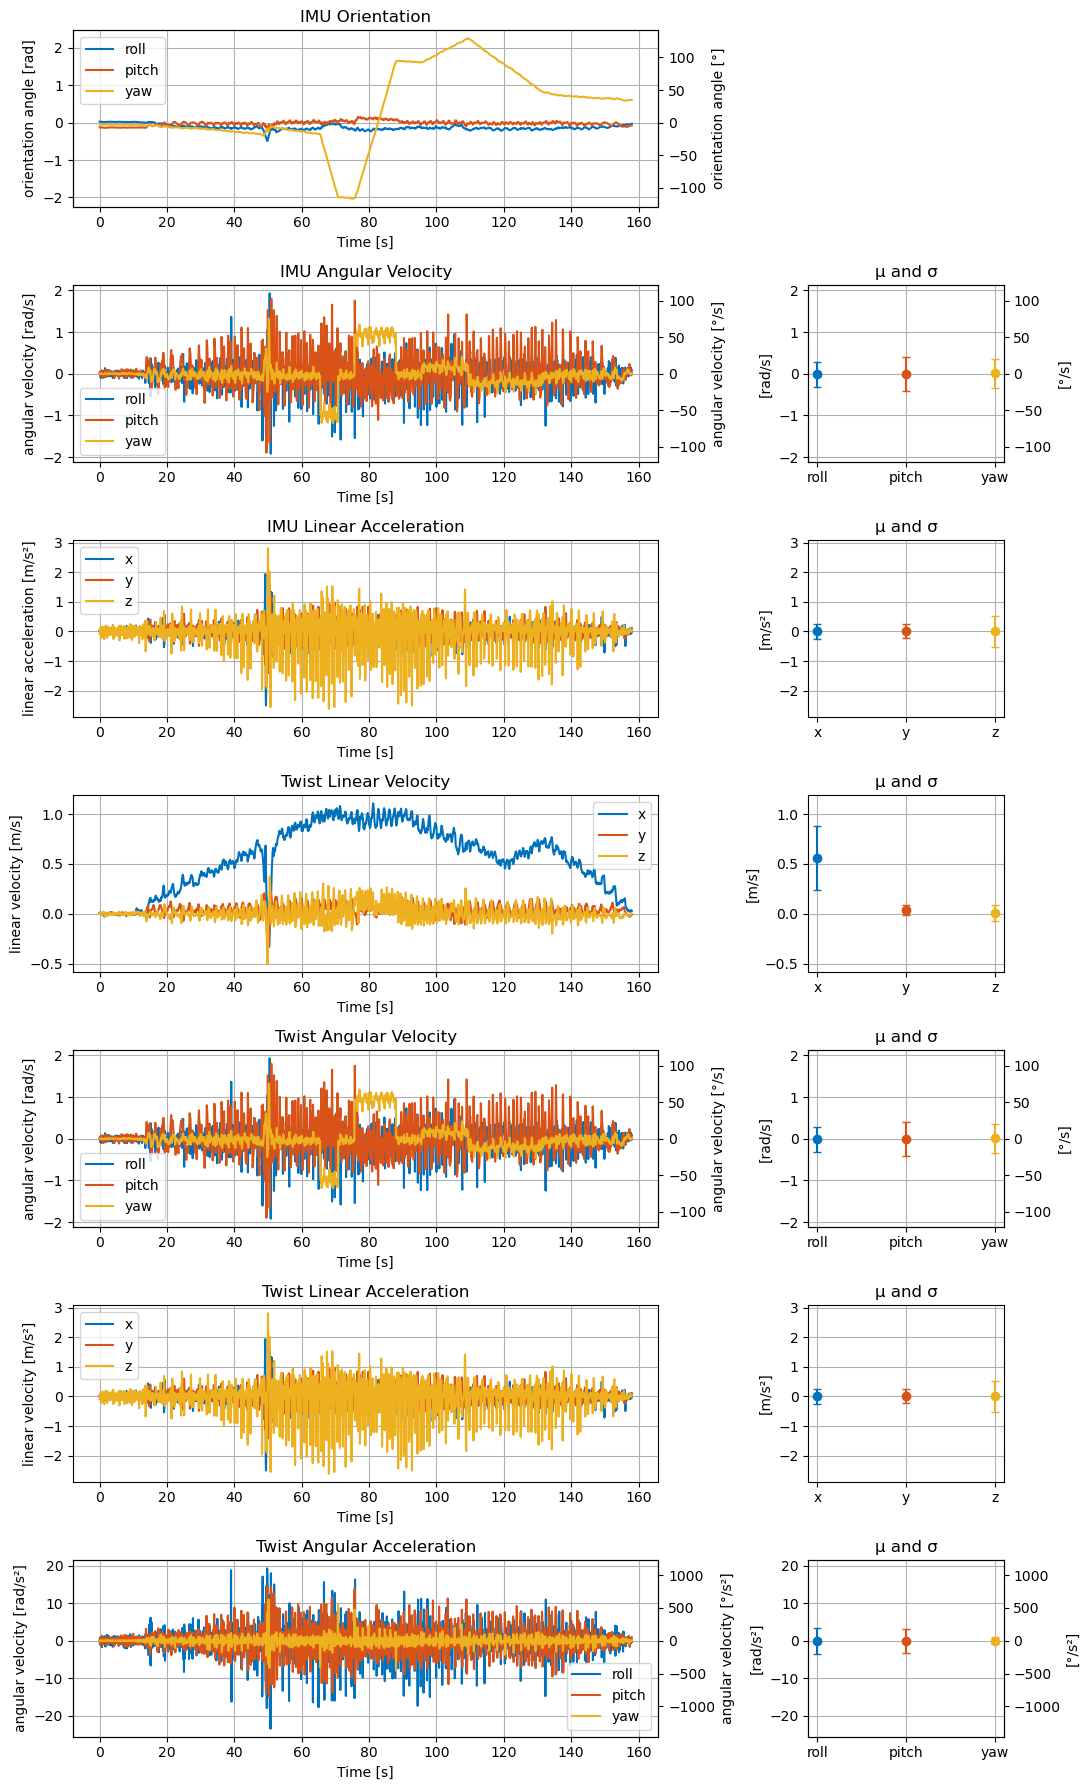

In [14]:
# Plot IMU and Twist data. Mean and standard deviation of linear and angular velocity and acceleration
import matplotlib.pyplot as plt
from statistics import mean
from statistics import stdev

def calc_gait_statistics(twist, twist_acc):
    # calculates mean and standard deviation of linear and angular velocity 

    # [[linear vel. (2)], [linear acc. (2)], [angular vel. (2)], [angular acc. (2)]]
    stats = [[[], []], [[], []], [[], []], [[], []]]

    for i in range(3): #for x,y and z
        #linear vel
        stats[0][0].append(mean(twist[1][i]))     
        stats[0][1].append(stdev(twist[1][i])) 
        #linear acc
        stats[1][0].append(mean(twist_acc[1][i]))     
        stats[1][1].append(stdev(twist_acc[1][i])) 
        #angular vel
        stats[2][0].append(mean(twist[2][i]))    
        stats[2][1].append(stdev(twist[2][i]))
        #angular acc
        stats[3][0].append(mean(twist_acc[2][i]))     
        stats[3][1].append(stdev(twist_acc[2][i])) 
    return stats

def plot_imu_twist(imu, twist, twist_acc, stats):
    fig, axs = plt.subplots(7, 2, figsize=(11, 18), gridspec_kw={'width_ratios': [3, 1]})
    
    axs[0, 0].plot(imu[0], imu[1][0], label='roll', color=BLUE)
    axs[0, 0].plot(imu[0], imu[1][1], label='pitch', color=ORANGE)
    axs[0, 0].plot(imu[0], imu[1][2], label='yaw', color=YELLOW)
    axs[0, 0].set_title('IMU Orientation')
    axs[0, 0].set_ylabel('orientation angle [rad]')
    axs[0, 0].set_xlabel('Time [s]')
    axs2 = axs[0, 0].twinx()
    axs2.set_ylim(np.rad2deg(axs[0, 0].get_ylim()))  
    axs2.set_ylabel('orientation angle [°]')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    
    axs[1, 0].plot(imu[0], imu[2][0], label='roll', color=BLUE)
    axs[1, 0].plot(imu[0], imu[2][1], label='pitch', color=ORANGE)
    axs[1, 0].plot(imu[0], imu[2][2], label='yaw', color=YELLOW)
    axs[1, 0].set_title('IMU Angular Velocity')
    axs[1, 0].set_xlabel('Time [s]')
    axs[1, 0].set_ylabel('angular velocity [rad/s]')
    axs2 = axs[1, 0].twinx()
    axs2.set_ylim(np.rad2deg(axs[1, 0].get_ylim()))  
    axs2.set_ylabel('angular velocity [°/s]')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    if SIMULATION:
        axs[2, 0].plot(twist_acc[0], twist_acc[1][0], label='x', color=BLUE)
        axs[2, 0].plot(twist_acc[0], twist_acc[1][1], label='y', color=ORANGE)
        axs[2, 0].plot(twist_acc[0], twist_acc[1][2], label='z', color=YELLOW)
    else:
        axs[2, 0].plot(imu[0], imu[3][0], label='x', color=BLUE)
        axs[2, 0].plot(imu[0], imu[3][1], label='y', color=ORANGE)
        axs[2, 0].plot(imu[0], imu[3][2], label='z', color=YELLOW)   
    
    axs[2, 0].set_title('IMU Linear Acceleration')
    axs[2, 0].set_xlabel('Time [s]')
    axs[2, 0].set_ylabel('linear acceleration [m/s²]')
    axs[2, 0].legend()
    axs[2, 0].grid(True)
    
    axs[3, 0].plot(twist[0], twist[1][0], label='x', color=BLUE)
    axs[3, 0].plot(twist[0], twist[1][1], label='y', color=ORANGE)
    axs[3, 0].plot(twist[0], twist[1][2], label='z', color=YELLOW)
    axs[3, 0].set_title('Twist Linear Velocity')
    axs[3, 0].set_xlabel('Time [s]')
    axs[3, 0].set_ylabel('linear velocity [m/s]')
    axs[3, 0].legend()
    axs[3, 0].grid(True)

    if SIMULATION:
        axs[4, 0].plot(twist[0], twist[2][0], label='roll', color=BLUE)
        axs[4, 0].plot(twist[0], twist[2][1], label='pitch', color=ORANGE)
        axs[4, 0].plot(twist[0], twist[2][2], label='yaw', color=YELLOW)
        axs[4, 0].set_title('Twist Angular Velocity')
        axs[4, 0].set_ylabel('angular velocity [rad/s]')
        axs[4, 0].set_xlabel('Time [s]')
        axs2 = axs[4, 0].twinx()
        axs2.set_ylim(np.rad2deg(axs[4, 0].get_ylim())) 
        axs2.set_ylabel('angular velocity [°/s]')
        axs[4, 0].legend()
        axs[4, 0].grid(True)

        axs[5, 0].plot(twist_acc[0], twist_acc[1][0], label='x', color=BLUE)
        axs[5, 0].plot(twist_acc[0], twist_acc[1][1], label='y', color=ORANGE)
        axs[5, 0].plot(twist_acc[0], twist_acc[1][2], label='z', color=YELLOW)
        axs[5, 0].set_title('Twist Linear Acceleration')
        axs[5, 0].set_xlabel('Time [s]')
        axs[5, 0].set_ylabel('linear velocity [m/s²]')
        axs[5, 0].legend()
        axs[5, 0].grid(True)

        axs[6, 0].plot(twist_acc[0], twist_acc[2][0], label='roll', color=BLUE)
        axs[6, 0].plot(twist_acc[0], twist_acc[2][1], label='pitch', color=ORANGE)
        axs[6, 0].plot(twist_acc[0], twist_acc[2][2], label='yaw', color=YELLOW)
        axs[6, 0].set_title('Twist Angular Acceleration')
        axs[6, 0].set_ylabel('angular velocity [rad/s²]')
        axs[6, 0].set_xlabel('Time [s]')
        axs2 = axs[6, 0].twinx()
        axs2.set_ylim(np.rad2deg(axs[6, 0].get_ylim())) 
        axs2.set_ylabel('angular velocity [°/s²]')
        axs[6, 0].legend()
        axs[6, 0].grid(True)

    else:
        axs[4, 0].plot(imu[0], twist[2][0], label='roll', color=BLUE)
        axs[4, 0].plot(imu[0], twist[2][1], label='pitch', color=ORANGE)
        axs[4, 0].plot(imu[0], twist[2][2], label='yaw', color=YELLOW)
        axs[4, 0].set_title('Twist Angular Velocity')
        axs[4, 0].set_ylabel('angular velocity [rad/s]')
        axs[4, 0].set_xlabel('Time [s]')
        axs2 = axs[4, 0].twinx()
        axs2.set_ylim(np.rad2deg(axs[4, 0].get_ylim())) 
        axs2.set_ylabel('angular velocity [°/s]')
        axs[4, 0].legend()
        axs[4, 0].grid(True)

        axs[5, 0].plot(imu[0], twist_acc[1][0], label='x', color=BLUE)
        axs[5, 0].plot(imu[0], twist_acc[1][1], label='y', color=ORANGE)
        axs[5, 0].plot(imu[0], twist_acc[1][2], label='z', color=YELLOW)
        axs[5, 0].set_title('Twist Linear Acceleration')
        axs[5, 0].set_xlabel('Time [s]')
        axs[5, 0].set_ylabel('linear velocity [m/s²]')
        axs[5, 0].legend()
        axs[5, 0].grid(True)

        axs[6, 0].plot(imu[0], twist_acc[2][0], label='roll', color=BLUE)
        axs[6, 0].plot(imu[0], twist_acc[2][1], label='pitch', color=ORANGE)
        axs[6, 0].plot(imu[0], twist_acc[2][2], label='yaw', color=YELLOW)
        axs[6, 0].set_title('Twist Angular Acceleration')
        axs[6, 0].set_ylabel('angular velocity [rad/s²]')
        axs[6, 0].set_xlabel('Time [s]')
        axs2 = axs[6, 0].twinx()
        axs2.set_ylim(np.rad2deg(axs[6, 0].get_ylim())) 
        axs2.set_ylabel('angular velocity [°/s²]')
        axs[6, 0].legend()
        axs[6, 0].grid(True)

    axs[0, 1].axis('off')

    label = ["x", "y", "z"]
    colors = [BLUE, ORANGE, YELLOW]
    for i, color in enumerate(colors):
        axs[3, 1].errorbar(label[i], stats[0][0][i], stats[0][1][i], capsize=3, fmt="o", color=color)
    axs[3, 1].grid(True)
    axs[3, 1].set_title("μ and σ")
    axs[3, 1].set_ylabel("[m/s]")
    axs[3, 1].set_ylim(axs[3, 0].get_ylim())

    for i, color in enumerate(colors):
        axs[2, 1].errorbar(label[i], stats[1][0][i], stats[1][1][i], capsize=3, fmt="o", color=color)
    axs[2, 1].grid(True)
    axs[2, 1].set_title("μ and σ")
    axs[2, 1].set_ylabel("[m/s²]")
    axs[2, 1].set_ylim(axs[2, 0].get_ylim())
    
    for i, color in enumerate(colors):
        axs[5, 1].errorbar(label[i], stats[1][0][i], stats[1][1][i], capsize=3, fmt="o", color=color)
    axs[5, 1].grid(True)
    axs[5, 1].set_title("μ and σ")
    axs[5, 1].set_ylabel("[m/s²]")
    axs[5, 1].set_ylim(axs[5, 0].get_ylim())

    label = ["roll", "pitch", "yaw"]
    for i, color in enumerate(colors):
        axs[1, 1].errorbar(label[i], stats[2][0][i], stats[2][1][i], capsize=3, fmt="o", color=color)
    axs[1, 1].grid(True)
    axs[1, 1].set_title("μ and σ")
    axs[1, 1].set_ylabel("[rad/s]")
    axs[1, 1].set_ylim(axs[1, 0].get_ylim())
    axs2 = axs[1, 1].twinx()
    axs2.set_ylim(np.rad2deg(axs[1, 1].get_ylim()))  # Set vertical limit
    axs2.set_ylabel('[°/s]')

    for i, color in enumerate(colors):
        axs[4, 1].errorbar(label[i], stats[2][0][i], stats[2][1][i], capsize=3, fmt="o", color=color)
    axs[4, 1].grid(True)
    axs[4, 1].set_title("μ and σ")
    axs[4, 1].set_ylabel("[rad/s]")
    axs[4, 1].set_ylim(axs[4, 0].get_ylim())
    axs2 = axs[4, 1].twinx()
    axs2.set_ylim(np.rad2deg(axs[4, 1].get_ylim()))  # Set vertical limit
    axs2.set_ylabel('[°/s]')

    for i, color in enumerate(colors):
        axs[6, 1].errorbar(label[i], stats[3][0][i], stats[3][1][i], capsize=3, fmt="o", color=color)
    axs[6, 1].grid(True)
    axs[6, 1].set_title("μ and σ")
    axs[6, 1].set_ylabel("[rad/s²]")
    axs[6, 1].set_ylim(axs[6, 0].get_ylim())
    axs2 = axs[6, 1].twinx()
    axs2.set_ylim(np.rad2deg(axs[6, 1].get_ylim()))  # Set vertical limit
    axs2.set_ylabel('[°/s²]')
    plt.tight_layout()

    plt.tight_layout()
    plt.savefig("IMU and Twist.pdf", format="pdf", bbox_inches="tight")

gait_stats = calc_gait_statistics(twist, twist_acc)
plot_imu_twist(imu, twist, twist_acc, gait_stats)

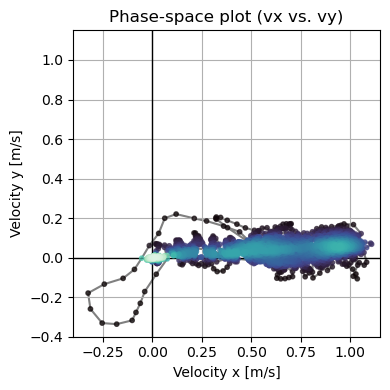

In [15]:
# Mean and standard deviation of linear and angular velocity and acceleration
import matplotlib.pyplot as plt
from statistics import mean
from statistics import stdev
from statistics import variance
from scipy.stats import gaussian_kde
import seaborn as sns

def calc_gait_statistics(twist, twist_acc):
    # calculates mean and standard deviation of linear and angular velocity 

    # [[linear vel. (2)], [linear acc. (2)], [angular vel. (2)], [angular acc. (2)]]
    stats = [[[], []], [[], []], [[], []], [[], []]]

    for i in range(3): #for x,y and z
        #linear vel
        stats[0][0].append(mean(twist[1][i]))     
        stats[0][1].append(stdev(twist[1][i])) 
        #linear acc
        stats[1][0].append(mean(twist_acc[1][i]))     
        stats[1][1].append(stdev(twist_acc[1][i])) 
        #angular vel
        stats[2][0].append(mean(twist[2][i]))    
        stats[2][1].append(stdev(twist[2][i]))
        #angular acc
        stats[3][0].append(mean(twist_acc[2][i]))     
        stats[3][1].append(stdev(twist_acc[2][i])) 
    return stats

def plot_gait_statistics(stats):  
    fig, axes = plt.subplots(1, 4, figsize=(13, 3))

    label = ["x", "y", "z"]
    colors = [BLUE, ORANGE, YELLOW]
    for i, color in enumerate(colors):
        axes[0].errorbar(label[i], stats[0][0][i], stats[0][1][i], capsize=3, fmt="o", color=color)
    axes[0].grid(True)
    axes[0].set_title("linear vel. mean and std. dev.")
    axes[0].set_ylabel("[m/s]")

    for i, color in enumerate(colors):
        axes[1].errorbar(label[i], stats[1][0][i], stats[1][1][i], capsize=3, fmt="o", color=color)
    axes[1].grid(True)
    axes[1].set_title("linear acc. mean and std. dev.")
    axes[1].set_ylabel("[m/s²]")
    
    label = ["roll", "pitch", "yaw"]
    for i, color in enumerate(colors):
        axes[2].errorbar(label[i], stats[2][0][i], stats[2][1][i], capsize=3, fmt="o", color=color)
    axes[2].grid(True)
    axes[2].set_title("angular vel.  mean and std. dev.")
    axes[2].set_ylabel("[rad/s]")
    axs2 = axes[2].twinx()
    axs2.set_ylim(np.rad2deg(axes[2].get_ylim()))  # Set vertical limit
    axs2.set_ylabel('[°/s]')

    for i, color in enumerate(colors):
        axes[3].errorbar(label[i], stats[3][0][i], stats[3][1][i], capsize=3, fmt="o", color=color)
    axes[3].grid(True)
    axes[3].set_title("angular acc.  mean and std. dev.")
    axes[3].set_ylabel("[rad/s²]")
    axs2 = axes[3].twinx()
    axs2.set_ylim(np.rad2deg(axes[3].get_ylim()))  # Set vertical limit
    axs2.set_ylabel('[°/s²]')
    plt.tight_layout()
    #plt.savefig("Velocity and Acceleration.pdf", format="pdf", bbox_inches="tight")

def plotPhaseSpace(twist):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    xy = np.vstack([twist[1][0], twist[1][1]])
    kde = gaussian_kde(xy)(xy)
    idx = kde.argsort() # Sort for better visualization
    vx, vy, kde = np.array(twist[1][0])[idx], np.array(twist[1][1])[idx], kde[idx]
    ax.axhline(linewidth=1, color="k")
    ax.axvline(linewidth=1, color="k")
    ax.plot(twist[1][0], twist[1][1], color='grey', zorder=1)
    ax.scatter(vx, vy, c=kde, cmap="mako", s=10, edgecolor=None, alpha=0.7, zorder=2) #edgecolor=None, s=50, alpha=0.7, legend='auto')
    ax.set_title('Phase-space plot (vx vs. vy)')
    ax.set_xlabel('Velocity x [m/s]')
    ax.set_ylabel('Velocity y [m/s]')
    ax.set_xlim([-0.4, 1.15])
    ax.set_ylim([-0.4, 1.15])
    ax.grid(True)
    plt.tight_layout()
    #plt.savefig("phaseSpacePlot.pdf", format="pdf", bbox_inches="tight")

if SIMULATION:
    plotPhaseSpace(twist)

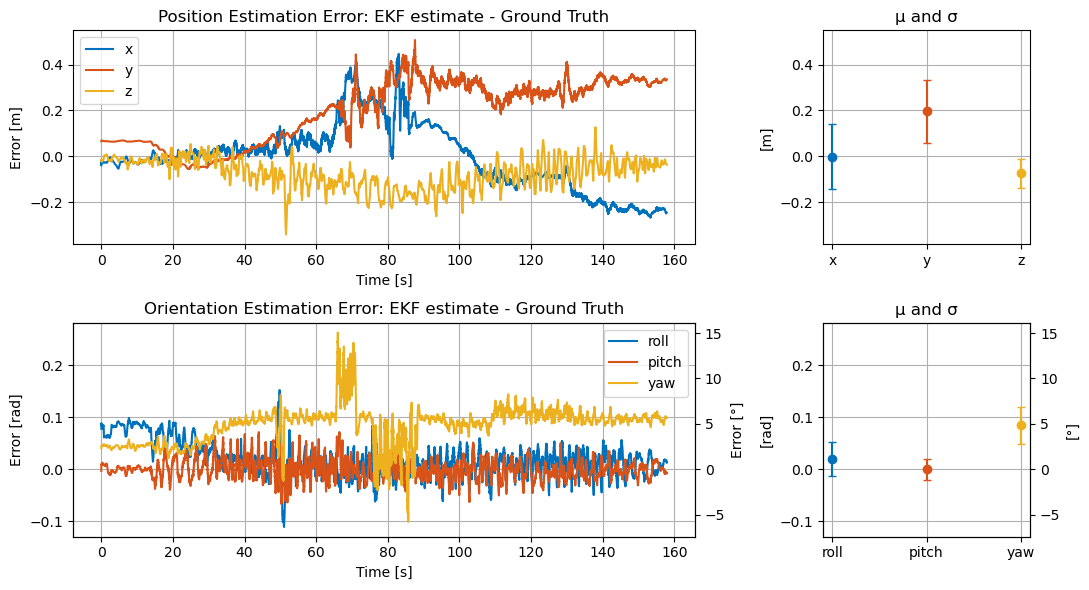

In [16]:
# Calculate and plot estimation error. Mean and standard deviation of estimation error.
from scipy.spatial.transform import Rotation as R

def calc_diff(list1, list2, tolerance_ns=1e6):
    # Calculate translation and rotation differences between two nested lists. Tolerance for timestamp matching in milliseconds (default is 1 ms).
    # return [[matched timestamps], [translation diff (3)], [rotation diff euler (3)]]

    calibration_offset = [0.315, 0, -0.125] # for tf offset of ground_truth
    
    t1_ = np.array(list1[0])
    t2_ = np.array(list2[0])

    trans1_ = np.array(list1[1])
    trans2_ = np.array(list2[1])
    rot1_ = np.array(list1[2]).T
    rot2_ = np.array(list2[2]).T

    matched_t_ = []
    trans_diff_ = [[], [], []]
    rot_diff_ = [[], [], [], []]
    rot_diff_euler_ = [[], [], []]

    # Iterate through timestamps in list1
    for i, t1 in enumerate(t1_):
        # Find the closest timestamp in list2
        time_diff = np.abs(t2_ - t1)
        closest_index = np.argmin(time_diff)

        # Check if the closest timestamp is within the tolerance
        if time_diff[closest_index] <= tolerance_ns * 1e-6:  # Convert ns to seconds
            matched_t_.append(t1)

            # Calculate translation difference
            translation_diff = trans1_[:, i] - trans2_[:, closest_index] - calibration_offset
            for j in range(3):
                trans_diff_[j].append(translation_diff[j])

            # Calculate rotation difference
            q1 = rot1_[i]
            q2 = rot2_[closest_index]

            # Create Rotation objects
            rot1__ = R.from_quat(q1)  # Input as [x, y, z, w]
            rot2__ = R.from_quat(q2)

            # Compute rotational difference: q_diff = q1 * q2^(-1)
            relative_rotation = rot1__ * rot2__.inv()
            q_diff = relative_rotation.as_quat()  # Returns [x, y, z, w]

            # convert to Euler angels
            rotation = R.from_quat([q_diff[0], q_diff[1], q_diff[2], q_diff[3]])
            euler = rotation.as_euler('xyz', degrees=False)  # 'xyz' corresponds to roll, pitch, yaw
            rot_diff_euler_[0].append(euler[0])
            rot_diff_euler_[1].append(euler[1])
            rot_diff_euler_[2].append(euler[2])
    
    return [matched_t_, trans_diff_, rot_diff_euler_]

def calc_localization_statistics(tf_diff):
    # calculates mean and standard deviation of linear and angular velocity 
    
    # [[position (2)], [orientation (2)]]
    stats = [[[], []], [[], []]]

    for i in range(3): #for x,y and z
        stats[0][0].append(mean(tf_diff[1][i]))     #position
        stats[0][1].append(stdev(tf_diff[1][i])) 
        stats[1][0].append(mean(tf_diff[2][i]))    #orientation
        stats[1][1].append(stdev(tf_diff[2][i]))
    return stats

def plot_tf(tf_diff, stats):   
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(11, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    # Plot position differences (x, y, z)
    axs[0, 0].plot(tf_diff[0], tf_diff[1][0], label='x', color=BLUE, marker='')
    axs[0, 0].plot(tf_diff[0], tf_diff[1][1], label='y', color=ORANGE, marker='')
    axs[0, 0].plot(tf_diff[0], tf_diff[1][2], label='z', color=YELLOW, marker='')
    axs[0, 0].set_title('Position Estimation Error: EKF estimate - Ground Truth')
    axs[0, 0].set_xlabel('Time [s]')
    axs[0, 0].set_ylabel('Error [m]')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot orientation differences (roll, pitch, yaw)
    axs[1, 0].plot(tf_diff[0], tf_diff[2][0], label='roll', color=BLUE, marker='')
    axs[1, 0].plot(tf_diff[0], tf_diff[2][1], label='pitch', color=ORANGE, marker='')
    axs[1, 0].plot(tf_diff[0], tf_diff[2][2], label='yaw', color=YELLOW, marker='')
    axs[1, 0].set_title('Orientation Estimation Error: EKF estimate - Ground Truth')
    axs[1, 0].set_xlabel('Time [s]')
    axs[1, 0].set_ylabel('Error [rad]')
    axs[1, 0].legend()
    axs[1, 0].grid(True)
    axs2 = axs[1, 0].twinx()
    axs2.set_ylim(np.rad2deg(axs[1, 0].get_ylim()))  # Set vertical limit
    axs2.set_ylabel('Error [°]')

    label = ["x", "y", "z"]
    colors = [BLUE, ORANGE, YELLOW]
    for i, color in enumerate(colors):
        axs[0, 1].errorbar(label[i], stats[0][0][i], stats[0][1][i], capsize=3, fmt="o", color=color)
    axs[0, 1].set_title("μ and σ")
    axs[0, 1].set_ylabel("[m]")
    axs[0, 1].grid(True)
    axs[0, 1].set_ylim(axs[0, 0].get_ylim())

    label = ["roll", "pitch", "yaw"]
    for i, color in enumerate(colors):
        axs[1, 1].errorbar(label[i], stats[1][0][i], stats[1][1][i], capsize=3, fmt="o", color=color)
    axs[1, 1].set_title("μ and σ")
    axs[1, 1].set_ylabel("[rad]")
    axs[1, 1].grid(True)
    axs[1, 1].set_ylim(axs[1, 0].get_ylim())
    axs2 = axs[1, 1].twinx()
    axs2.set_ylim(np.rad2deg(axs[1, 1].get_ylim()))  # Set vertical limit
    axs2.set_ylabel('[°]')

    plt.tight_layout()
    plt.savefig("estimation Error.pdf", format="pdf", bbox_inches="tight")

if SIMULATION:
    tf_diff = calc_diff(tf, tf_gt)
    localization_stats = calc_localization_statistics(tf_diff)
    plot_tf(tf_diff, localization_stats)

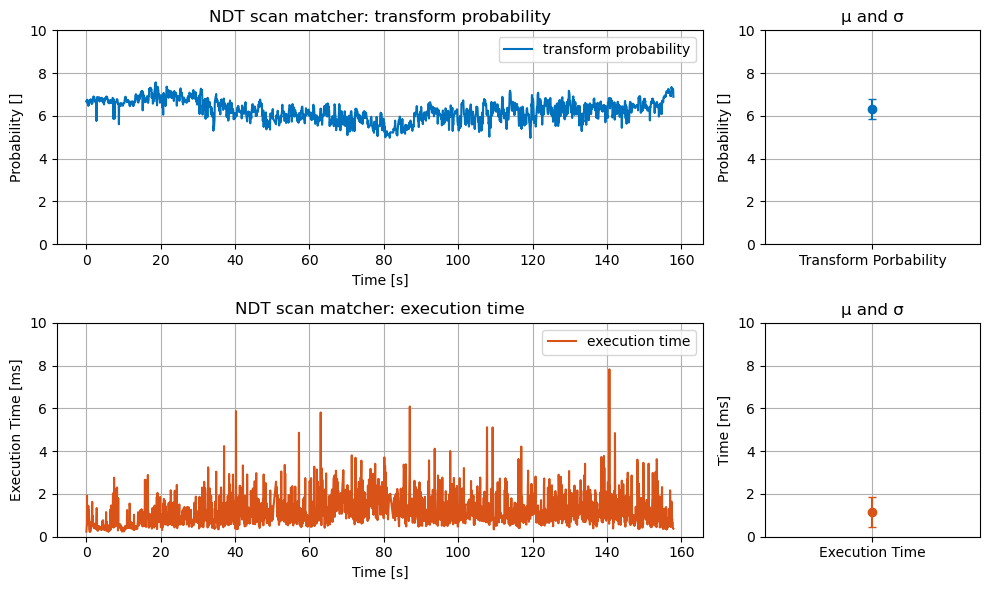

In [17]:
# Plot NDT scan matcher diagnostics. Mean and standard deviation of NDT scan matcher diagnostics
def calc_NDTdiagnostics_statistics(diagnostics):
    # calculates mean and standard deviation of linear and angular velocity 
    
    # [[transform probability (2)], [execution time (2)]]
    stats = [[[], []], [[], []]]

    stats[0][0].append(mean(diagnostics[1]))    #transform probability
    stats[0][1].append(stdev(diagnostics[1])) 
    stats[1][0].append(mean(diagnostics[2]))    #execution time
    stats[1][1].append(stdev(diagnostics[2]))
    return stats

def plot_ndt_stats(diagnostics, stats):   
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    # Plot position differences (x, y, z)
    axs[0, 0].plot(diagnostics[0], diagnostics[1], label='transform probability', color=BLUE)
    axs[0, 0].set_title('NDT scan matcher: transform probability')
    axs[0, 0].set_xlabel('Time [s]')
    axs[0, 0].set_ylabel('Probability []')
    axs[0, 0].grid(True)
    axs[0, 0].legend()
    axs[0, 0].set_ylim([0, 10])
    
    axs[1, 0].plot(diagnostics[0], diagnostics[2], label='execution time', color=ORANGE)
    axs[1, 0].set_ylabel('Execution Time [ms]')
    axs[1, 0].set_title('NDT scan matcher: execution time')
    axs[1, 0].set_xlabel('Time [s]')
    axs[1, 0].grid(True)
    axs[1, 0].legend()
    axs[1, 0].set_ylim([0, 10])

    axs[0, 1].errorbar(["Transform Porbability"], stats[0][0], stats[0][1], capsize=3, fmt="o", color=BLUE)
    axs[0, 1].set_title("μ and σ")
    axs[0, 1].set_ylabel("Probability []")
    axs[0, 1].set_ylim([0, 10])
    axs[0, 1].grid(True)

    axs[1, 1].errorbar(["Execution Time"], stats[1][0], stats[1][1], capsize=3, fmt="o", color=ORANGE)
    axs[1, 1].set_title("μ and σ")
    axs[1, 1].set_ylabel("Time [ms]")#
    axs[1, 1].set_ylim([0, 10])
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig("NDT diagnostics.pdf", format="pdf", bbox_inches="tight")

ndt_diagnostics_stats = calc_NDTdiagnostics_statistics(ndt_diagnostics)
plot_ndt_stats(ndt_diagnostics, ndt_diagnostics_stats)

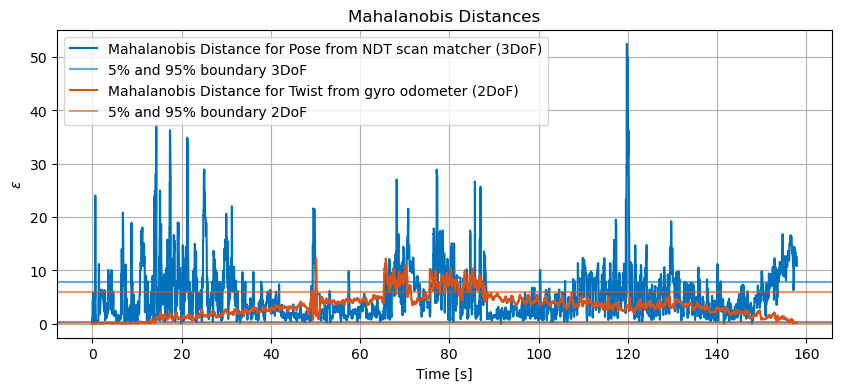

In [18]:
# Calc and plot mahalanobis distance stats
import scipy.stats as stats

def analyze_mahalanobis(list_, dof):
    decimals = 1
    total = len(list_)
    
    if total == 0:
        return 0.0, 0.0, 0.0
        
    below = 0
    between = 0
    above = 0

    lower = stats.chi2.ppf(0.05, dof)
    upper = stats.chi2.ppf(0.95, dof)
    
    for value in list_:
        if value < lower:
            below += 1
        elif lower <= value <= upper:
            between += 1
        else:
            above += 1
        
    # Calculate the percentages
    below = (below / total) * 100
    between = (between / total) * 100
    above = (above / total) * 100
    return round(below, decimals), round(between, decimals), round(above, decimals)

def plot_mahalanobis(diagnostics):
    # Critical values for the 90% confidence interval (5% and 95% percentiles)
    lower_2 = stats.chi2.ppf(0.05, 2)  # 5% left-tail for dof=2
    upper_2 = stats.chi2.ppf(0.95, 2)  # 95% right-tail for dof=2
    lower_3 = stats.chi2.ppf(0.05, 3)  # 5% left-tail for dof=3
    upper_3 = stats.chi2.ppf(0.95, 3)  # 95% right-tail for dof=3
    
    plt.figure(figsize=(10, 4))   
    plt.plot(diagnostics[0], diagnostics[1], label='Mahalanobis Distance for Pose from NDT scan matcher (3DoF)', color=BLUE)
    plt.axhline(y=lower_3, color=BLUE, alpha=0.6, label='5% and 95% boundary 3DoF')
    plt.axhline(y=upper_3, color=BLUE, alpha=0.6)
    plt.plot(diagnostics[0], diagnostics[2], label='Mahalanobis Distance for Twist from gyro odometer (2DoF)', color=ORANGE)
    plt.axhline(y=lower_2, color=ORANGE, alpha=0.6, label='5% and 95% boundary 2DoF')
    plt.axhline(y=upper_2, color=ORANGE, alpha=0.6)
    plt.title('Mahalanobis Distances')
    plt.xlabel('Time [s]')
    plt.ylabel(r'$\varepsilon$')
    plt.legend(loc='upper left')
    plt.grid(True)
    #plt.savefig("Mahalanobis.pdf", format="pdf", bbox_inches="tight")

if SIMULATION:
    plot_mahalanobis(ekf_diagnostics)

In [19]:
# Evaluation Table
from tabulate import tabulate
from openpyxl import Workbook

def gait_and_localization_evaluation(rosbag_list):
    root="/home/kinbergeradm/bag_files/gait_localization_evaluation/"
    headers = ["#", "rosbag", "description", "linear velocity μ [m/s]", "linear velocity σ [m/s]", "linear acc. μ [m/s²]", "linear acc. σ [m/s²]",
               "angular velocity μ [rad/s]", "angular velocity σ [rad/s]", "angular acc. μ [rad/s²]", "angular acc. σ [rad/s²]", 
               "NDT TP μ []", "NDT TP σ []", "NDT execution time μ [s]", "NDT execution time σ [s]", 
               "Mahalanobis pose []", "Mahalanobis twist []", 
               "position est. error μ [m]", "position est. error σ [m]", "orientation est. error μ [°]", "orientation est. error σ [°]"]
    data = []
    decimals = 2

    for bag_info in rosbag_list:
        data.append([])
        data[-1].append(len(data))
        data[-1].append(bag_info[0][8:28])
        data[-1].append(bag_info[2])

        if bag_info[1]:
            imu_, twist_, ndt_diagnostics_, ekf_diagnostics_, tf_, tf_gt_ = extract_rosbag(root+bag_info[0], bag_info[1])
        else:
            imu_, twist_, ndt_diagnostics_ = extract_rosbag(root+bag_info[0], bag_info[1])
            imu_ = filter_imu(imu_)
        twist_, twist_acc_ = calc_derivation(twist_, imu_)
        
        gait_stats_ = calc_gait_statistics(twist_, twist_acc_)
        data[-1].append(np.around(gait_stats_[0][0],decimals))
        data[-1].append(np.around(gait_stats_[0][1],decimals))
        data[-1].append(np.around(gait_stats_[1][0],decimals))
        data[-1].append(np.around(gait_stats_[1][1],decimals))
        data[-1].append(np.around(gait_stats_[2][0],decimals))
        data[-1].append(np.around(gait_stats_[2][1],decimals))
        data[-1].append(np.around(gait_stats_[3][0],decimals))
        data[-1].append(np.around(gait_stats_[3][1],decimals))
        
        ndt_stats_ = calc_NDTdiagnostics_statistics(ndt_diagnostics_)
        data[-1].append(np.round(ndt_stats_[0][0],decimals))
        data[-1].append(np.round(ndt_stats_[0][1],decimals))
        data[-1].append(np.round(ndt_stats_[1][0],decimals))
        data[-1].append(np.round(ndt_stats_[1][1],decimals))

        
        
        if bag_info[1]:
            data[-1].append(analyze_mahalanobis(ekf_diagnostics_[1], 3))
            data[-1].append(analyze_mahalanobis(ekf_diagnostics_[2], 2))
            tf_diff_ = calc_diff(tf_, tf_gt_)
            loc_stats_ = calc_localization_statistics(tf_diff_)
            data[-1].append(np.around(loc_stats_[0][0],decimals))
            data[-1].append(np.around(loc_stats_[0][1],decimals))
            data[-1].append(np.around(np.rad2deg(loc_stats_[1][0]),decimals))
            data[-1].append(np.around(np.rad2deg(loc_stats_[1][1]),decimals))
        else:
            data[-1].append("--")
            data[-1].append("--")
            data[-1].append("--")
            data[-1].append("--")
            data[-1].append("--")
            data[-1].append("--")

    # Transpose the table to make headers vertical
    transposed_data = [[header] + [(row[i] if not isinstance(row[i], np.ndarray) or row[i].size > 1 else row[i].item()) for row in data] for i, header in enumerate(headers)]
    print(tabulate(transposed_data, tablefmt="simple_grid", numalign="decimal", stralign="center"))
    
    wb = Workbook()
    ws = wb.active  # Access the active worksheet
    for row_index, sublist in enumerate(transposed_data, start=1):
        for col_index, value in enumerate(sublist, start=1):
            ws.cell(row=row_index, column=col_index, value=str(value))
    wb.save("Evaluation Table.xlsx")

    return transposed_data

table = gait_and_localization_evaluation(rosbag_list)

In [20]:
# Plot Errorbar for all rosbags
from matplotlib.transforms import Affine2D

def plot_errorbars(table_):
    label = ["#1", "#2", "#3", "#4", "#5", "#6", "#7", "#8"]
    fig, ax = plt.subplots(5, 1, figsize=(8, 12))
    
    trans1 = Affine2D().translate(-0.15, 0.0) + ax[0].transData
    trans2 = Affine2D().translate(+0.15, 0.0) + ax[0].transData
    for i in range(1, len(table_[3])):
        ax[0].errorbar(label[i-1], table_[3][i][0], table_[4][i][0], label = "x", fmt="o", capsize=3, color=BLUE, transform=trans1)
        ax[0].errorbar(label[i-1], table_[3][i][1], table_[4][i][1], label = "y", fmt="o", capsize=3, color=ORANGE)
        ax[0].errorbar(label[i-1], table_[3][i][2], table_[4][i][2], label = "z", fmt="o", capsize=3, color=YELLOW, transform=trans2)
    ax[0].legend(["x", "y", "z"], loc = 'upper center')
    ax[0].grid(True)
    ax[0].set_title('linear Velocity μ and σ')
    ax[0].set_ylabel('[m/s]')

    trans1 = Affine2D().translate(-0.15, 0.0) + ax[1].transData
    trans2 = Affine2D().translate(+0.15, 0.0) + ax[1].transData
    for i in range(1, len(table_[3])):
        ax[1].errorbar(label[i-1], table_[7][i][0], table_[8][i][0], label = "x", fmt="o", capsize=3, color=BLUE, transform=trans1)
        ax[1].errorbar(label[i-1], table_[7][i][1], table_[8][i][1], label = "y", fmt="o", capsize=3, color=ORANGE)
        ax[1].errorbar(label[i-1], table_[7][i][2], table_[8][i][2], label = "z", fmt="o", capsize=3, color=YELLOW, transform=trans2)
    ax[1].legend(["roll", "pitch", "yaw"], loc = 'lower right')
    ax[1].grid(True)
    ax[1].set_title('angular Velocity μ and σ')
    ax[1].set_ylabel('[rad/s]')
    axs2 = ax[1].twinx()
    axs2.set_ylim(np.rad2deg(ax[1].get_ylim()))  # Set vertical limit
    axs2.set_ylabel('[°/s]')

    trans1 = Affine2D().translate(-0.15, 0.0) + ax[2].transData
    trans2 = Affine2D().translate(+0.15, 0.0) + ax[2].transData
    for i in range(1, len(table_[3])-2):
        ax[2].errorbar(label[i-1], table_[17][i][0], table_[18][i][0], label = "x", fmt="o", capsize=3, color=BLUE, transform=trans1)
        ax[2].errorbar(label[i-1], table_[17][i][1], table_[18][i][1], label = "y", fmt="o", capsize=3, color=ORANGE)
        ax[2].errorbar(label[i-1], table_[17][i][2], table_[18][i][2], label = "z", fmt="o", capsize=3, color=YELLOW, transform=trans2)
    ax[2].errorbar(label[6],0,0)
    ax[2].errorbar(label[7],0,0)
    ax[2].legend(["x", "y", "z"], loc = 'lower right')
    ax[2].grid(True)
    ax[2].set_title('Position Estimation Error μ and σ')
    ax[2].set_ylabel('[m]')

    trans1 = Affine2D().translate(-0.15, 0.0) + ax[3].transData
    trans2 = Affine2D().translate(+0.15, 0.0) + ax[3].transData
    for i in range(1, len(table_[3])-2):
        ax[3].errorbar(label[i-1], np.deg2rad(table_[19][i][0]), np.deg2rad(table_[20][i][0]), label = "x", fmt="o", capsize=3, color=BLUE, transform=trans1)
        ax[3].errorbar(label[i-1], np.deg2rad(table_[19][i][1]), np.deg2rad(table_[20][i][1]), label = "y", fmt="o", capsize=3, color=ORANGE)
        ax[3].errorbar(label[i-1], np.deg2rad(table_[19][i][2]), np.deg2rad(table_[20][i][2]), label = "z", fmt="o", capsize=3, color=YELLOW, transform=trans2)
    ax[3].errorbar(label[6],0,0)
    ax[3].errorbar(label[7],0,0)
    ax[3].legend(["roll", "pitch", "yaw"], loc = 'lower right')
    ax[3].grid(True)
    ax[3].set_title('Orientation Estimation Error μ and σ')
    ax[3].set_ylabel('[rad]')
    axs2 = ax[3].twinx()
    axs2.set_ylim(np.rad2deg(ax[3].get_ylim()))  # Set vertical limit
    axs2.set_ylabel('[°]')

    for i in range(1, len(table_[3])):
        ax[4].errorbar(label[i-1], table_[11][i], table_[12][i], fmt="o", capsize=3, color=BLUE)
    ax[4].grid(True)
    ax[4].set_title('NDT transform probability μ and σ')
    ax[4].set_ylabel('[]')
    
    fig.tight_layout()
    fig.savefig("Errorbars.pdf", format="pdf", bbox_inches="tight")

plot_errorbars(table)

In [43]:
# Create correlation matrix
import pandas as pd
import seaborn as sns
from matplotlib.patheffects import withStroke
from matplotlib.cm import ScalarMappable
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import linregress

def align_data(listing):
    # Make aligned list for correlation matrix calculation
    
    def append_data(list_):
        for i in range(1,len(list_)):
            if len(list_[1])>3:
                lists.append([list_[0], list_[i]])
            else:
                for j in range(len(list_[1])):
                    lists.append([list_[0], list_[i][j]])           
    lists = []
    for i in range(len(listing)):
        append_data(listing[i])
    
    # Find the shortest list
    shortest_list = min(lists, key=lambda x: len(x[0]))
    num_lists = len(lists)
    
    # Initialize aligned data lists
    aligned_data = [[] for _ in range(num_lists)]
    
    # Align data for each timestamp in the shortest list
    for t in shortest_list[0]:
        for i, (timestamp, data) in enumerate(lists):
            # Find the index of the closest timestamp
            closest_index = min(range(len(timestamp)), key=lambda x: abs(timestamp[x] - t))
            # Append the corresponding data
            aligned_data[i].append(data[closest_index])

    return pd.DataFrame(aligned_data).transpose()


def apply_absolut(twist_, twist_acc_, tf_diff_):
    for i in range(3):
        twist_[1][i] = np.abs(twist_[1][i])
        twist_[2][i] = np.abs(twist_[2][i])
        twist_acc_[1][i] = np.abs(twist_acc_[1][i])
        twist_acc_[2][i] = np.abs(twist_acc_[2][i])
        tf_diff_[1][i] = np.abs(tf_diff_[1][i])
        tf_diff_[2][i] = np.abs(tf_diff_[2][i])

    return twist_, twist_acc_, tf_diff_


def plot_seaborn(data_, path_, suffix_=""):
    def annotate(*args, **kwargs):
        num_bins = int(np.sqrt(len(args[0])))  # Use square-root rule for bin count
        bin_edges1 = np.histogram_bin_edges(args[0], bins=num_bins)
        bin_edges2 = np.histogram_bin_edges(args[1], bins=num_bins)
        discrete_data1_ = np.digitize(args[0], bins=bin_edges1)
        discrete_data2_ = np.digitize(args[1], bins=bin_edges2)
        mi = normalized_mutual_info_score(discrete_data1_, discrete_data2_)
        corr_r = args[0].corr(args[1], 'pearson')
        ax = plt.gca()
        text = ax.annotate("r="+f"{corr_r:2.2f}"+" mi="+f"{mi:2.2f}", [.05, .05,],  xycoords="axes fraction", fontsize=14)
        text.set_path_effects([withStroke(linewidth=5, foreground="white")])  # White border
        
    def corrdot(*args, **kwargs):
        corr_r = args[0].corr(args[1], 'pearson')
        ax = plt.gca()
        ax.set_axis_off()
        marker_size = 50000 #abs(corr_r) * 10000
        ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
                   vmin=-1, vmax=1, transform=ax.transAxes)
        ax.annotate(f"{corr_r:2.2f}", [.5, .5,],  xycoords="axes fraction",
                    ha='center', va='center', fontsize=16)

    def reggresion(*args, **kwargs):       
        sns.regplot(x=args[0], y=args[1], scatter=False)
        ax = plt.gca()
        ax.grid(True)
        ax.set_xlim(left=0)
        ax.set_ylim([0, 1])
        #ax.figure.set_size_inches(4, 4)
    
        slope, intercept, _, _, _ = linregress(args[0], args[1])
        y_value = 0.5
        x_value = (y_value - intercept) / slope
        print(f"x corresponding to y = {y_value} is {x_value}")

    def midot(*args, **kwargs):
        # Discretize data for mutual information calculation
        num_bins = int(np.sqrt(len(args[0])))  # Use square-root rule for bin count
        bin_edges1 = np.histogram_bin_edges(args[0], bins=num_bins)
        bin_edges2 = np.histogram_bin_edges(args[1], bins=num_bins)
        discrete_data1_ = np.digitize(args[0], bins=bin_edges1)
        discrete_data2_ = np.digitize(args[1], bins=bin_edges2)
        mutual_info = normalized_mutual_info_score(discrete_data1_, discrete_data2_)
        ax = plt.gca()
        ax.set_axis_off()
        marker_size = 50000 #abs(mutual_info) * 10000
        ax.scatter([.5], [.5], marker_size, [mutual_info], alpha=0.6, cmap="coolwarm",
                   vmin=-1, vmax=1, transform=ax.transAxes)
        ax.annotate(f"{mutual_info:2.2f}", [.5, .5,],  xycoords="axes fraction",
                    ha='center', va='center', fontsize=14)

    def scatter_density(*args, **kwargs):
        xy = np.vstack([args[0], args[1]])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        x, y, z = args[0][idx], args[1][idx], z[idx]
        sns.scatterplot(x=x, y=y, hue=z, palette="mako", edgecolor=None, s=50, alpha=0.7, legend='auto')

    sns.set(style="white", font_scale=1.2)
    # comment out certain lines for different options #1, #2 or #3
    # comment out either lines with #1 or #2 at the end
    #g = sns.PairGrid(data_) #1
    #g.map_upper(corrdot) #1
    #g.map_lower(scatter_density) #1
    #g.map_diag(sns.histplot, linewidth=0, color=ScalarMappable(cmap="mako").to_rgba(0)) #1
    #x_vars=data_.columns[0:6] #2
    #y_vars=data_.columns[6-len(data_.columns):] #2
    x_vars=data_.columns[0:6] #3
    y_vars=data_.columns[6:] #3
    g = sns.PairGrid(data_, diag_sharey=False, x_vars=x_vars, y_vars=y_vars) #2 and #3
    #g.map_offdiag(scatter_density) #2
    #g.map_offdiag(annotate) #2
    g.map_offdiag(reggresion) #3
    plt.tight_layout()
    if len(y_vars) == 1:
        g.fig.subplots_adjust(top=1)
    elif len(y_vars) == 2:
        g.fig.subplots_adjust(top=0.92)
    else:
        g.fig.subplots_adjust(top=0.96)
    #g.fig.suptitle("Correlation Matrix " + path_[-27:] + suffix_, fontsize=16) #1 and #2
    plt.savefig(str("correlationMatrix_" + path_[-27:] + suffix_ + ".pdf"), format="pdf", bbox_inches="tight")
    sns.set(font_scale=1)
    plt.style.use('default')

    
def make_corr_matrix(path_, filter_=False, absolut_=False):
    # Read rosbag
    imu, twist, ndt_diagnostics, ekf_diagnostics, tf, tf_gt = extract_rosbag(path_, True)
    twist_acc = calc_derivation(twist, imu)
    if filter_:
        imu, twist, ndt_diagnostics, ekf_diagnostics, tf, tf_gt, twist_acc = filter_all_data(imu, twist, ndt_diagnostics, ekf_diagnostics, tf, tf_gt, twist_acc)
    tf_diff = calc_diff(tf, tf_gt)
    if absolut_:
        twist, twist_acc, tf_diff = apply_absolut(twist, twist_acc, tf_diff)

    # Align Data
    #(imu, twist, ndt_diagnostics, ekf_diagnostics, tf_diff)
    data = align_data([twist, ekf_diagnostics])
    
    # Column names
    # "liner vel. x","liner vel. y","liner vel. z", "angular vel. roll", "angular vel. pitch", "angular vel. yaw", 
    # "liner acc. x","liner acc. y","liner acc. z", "angular acc. roll", "angular acc. pitch", "angular acc. yaw", 
    # "estimation error x","estimation error y","estimation error z","estimation error roll", "estimation error pitch", "estimation error yaw"
    # "mahalanobis twist", "mahalanobis pose"
    # "transform probability", "execution time"
    data.columns = ["liner vel. x","liner vel. y","liner vel. z", "angular vel. roll", "angular vel. pitch", "angular vel. yaw",  
                    "mahalanobis twist", "mahalanobis pose"]
    # Make plot
    plot_seaborn(data, path_)


def make_all_corr_matrix(path_, filter_=False, absolut_=False):
    root = "/home/kinbergeradm/bag_files/gait_localization_evaluation/"
    imu, twist, ndt_diagnostics, ekf_diagnostics, tf, tf_gt = extract_rosbag(root+path_, True)
    twist_acc = calc_derivation(twist, imu)
    suffix = ""
    if filter_:
        imu, twist, ndt_diagnostics, ekf_diagnostics, tf, tf_gt, twist_acc = filter_all_data(imu, twist, ndt_diagnostics, ekf_diagnostics, tf, tf_gt, twist_acc)
        suffix = "_filtered"
    tf_diff = calc_diff(tf, tf_gt)
    if absolut_:
        twist, twist_acc, tf_diff = apply_absolut(twist, twist_acc, tf_diff)
        suffix = suffix + "_absolut"

    data = align_data([twist_acc, ndt_diagnostics])
    data.columns = ["liner acc. x","liner acc. y","liner acc. z", "angular acc. roll", "angular acc. pitch", "angular acc. yaw", "transform probability", "execution time"]
    plot_seaborn(data, path_, suffix+"_acceleration_vs_ndt")
    #plt.close()

    data = align_data([twist_acc, ekf_diagnostics])
    data.columns = ["liner acc. x","liner acc. y","liner acc. z", "angular acc. roll", "angular acc. pitch", "angular acc. yaw", "mahalanobis twist", "mahalanobis pose"]
    plot_seaborn(data, path_, suffix+"_acceleration_vs_ekf")
    #plt.close()

    data = align_data([twist_acc, tf_diff])
    data.columns = ["liner acc. x","liner acc. y","liner acc. z", "angular acc. roll", "angular acc. pitch", "angular acc. yaw", 
                    "estimation error x","estimation error y","estimation error z","estimation error roll", "estimation error pitch", "estimation error yaw"]
    plot_seaborn(data, path_, suffix+"_acceleration_vs_esterror")
    #plt.close()

    data = align_data([twist, ndt_diagnostics])
    data.columns = ["liner vel. x","liner vel. y","liner vel. z", "angular vel. roll", "angular vel. pitch", "angular vel. yaw", "transform probability", "execution time"]
    plot_seaborn(data, path_, suffix+"_velocity_vs_ndt")
    #plt.close()

    data = align_data([twist, ekf_diagnostics])
    data.columns = ["liner vel. x","liner vel. y","liner vel. z", "angular vel. roll", "angular vel. pitch", "angular vel. yaw", "mahalanobis twist", "mahalanobis pose"]
    plot_seaborn(data, path_, suffix+"_velocity_vs_ekf")
    #plt.close()

    data = align_data([twist, tf_diff])
    data.columns = ["liner vel. x","liner vel. y","liner vel. z", "angular vel. roll", "angular vel. pitch", "angular vel. yaw", 
                    "estimation error x","estimation error y","estimation error z","estimation error roll", "estimation error pitch", "estimation error yaw"]
    plot_seaborn(data, path_, suffix+"_velocity_vs_esterror")
    #plt.close()
    
    
#make_corr_matrix(rosbag_path, True, True)

#make_all_corr_matrix(rosbag_list[6][0], filter_=False, absolut_=True)

for path in rosbag_list:
    make_all_corr_matrix(path[0], filter_=False, absolut_=True)

[INFO] [1737553964.789754436] [rosbag2_storage]: Opened database '/home/kinbergeradm/bag_files/gait_localization_evaluation/rosbag2_2024_12_03-10_34_42/rosbag2_2024_12_03-10_34_42_0.db3' for READ_ONLY.


x corresponding to y = 0.5 is 0.8352154401859905
x corresponding to y = 0.5 is 0.1610011585513179
x corresponding to y = 0.5 is 0.1481310927947599
x corresponding to y = 0.5 is 0.8971283688749232
x corresponding to y = 0.5 is 1.2558718946518093
x corresponding to y = 0.5 is 0.5278382774237177


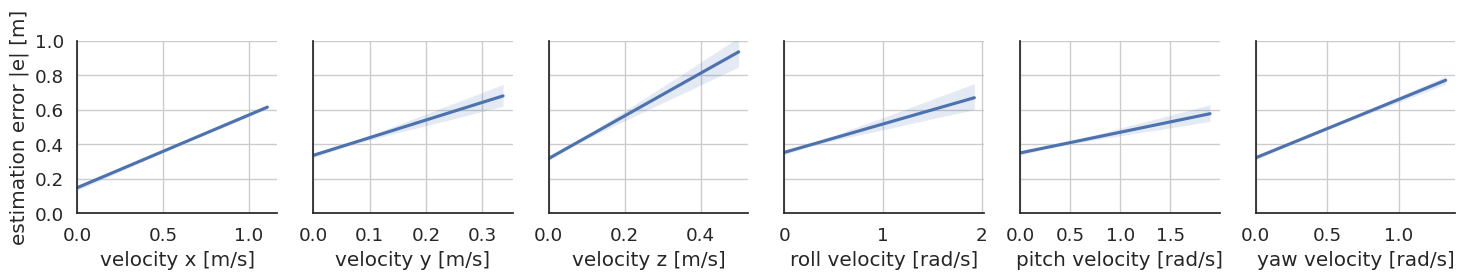

In [44]:
# Correlation matrix for the sum of the estimation error and velocity

def make_corr_matrix_vel_vs_sumesterror(path_):
    # Read rosbag
    imu, twist, ndt_diagnostics, ekf_diagnostics, tf, tf_gt = extract_rosbag(path_, True)
    tf_diff = calc_diff(tf, tf_gt)
    for i in range(3):
        twist[1][i] = np.abs(twist[1][i])
        twist[2][i] = np.abs(twist[2][i])
        tf_diff[1][i] = np.abs(tf_diff[1][i])
        tf_diff[2][i] = np.abs(tf_diff[2][i])

    tf_diff[1][0] = np.array(tf_diff[1][0]) + np.array(tf_diff[1][1]) + np.array(tf_diff[1][2])
    tf_diff[2][0] = np.array(tf_diff[2][0]) + np.array(tf_diff[2][1]) + np.array(tf_diff[2][2])

    # Align Data
    #(imu, twist, ndt_diagnostics, ekf_diagnostics, tf_diff)
    data = align_data([twist, tf_diff])
    
    # Column names
    # "linear vel. x","linear vel. y","linear vel. z", "angular vel. roll", "angular vel. pitch", "angular vel. yaw", 
    # "linear acc. x","linear acc. y","linear acc. z", "angular acc. roll", "angular acc. pitch", "angular acc. yaw", 
    # "estimation error x","estimation error y","estimation error z","estimation error roll", "estimation error pitch", "estimation error yaw"
    # "mahalanobis twist", "mahalanobis pose"
    # "transform probability", "execution time"
    data.columns = ["velocity x [m/s]","velocity y [m/s]","velocity z [m/s]", "roll velocity [rad/s]", "pitch velocity [rad/s]", "yaw velocity [rad/s]",  
                    "estimation error |e| [m]","estimation error y","estimation error z","estimation error |e| [rad]", "estimation error pitch", "estimation error yaw"]

    data = data.drop(columns=[#"velocity y [m/s]","velocity z [m/s]", "roll velocity [rad/s]", "pitch velocity [rad/s]", "yaw velocity [rad/s]",
                              "estimation error y","estimation error z", "estimation error |e| [rad]", "estimation error pitch", "estimation error yaw"])
    
    # Make plot
    plot_seaborn(data, path_)

make_corr_matrix_vel_vs_sumesterror(rosbag_path)